In [1]:
!pip install -q transformers datasets scikit-learn matplotlib seaborn numpy pandas

In [2]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix


In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


device(type='cuda')

In [13]:
MODEL_DIR = "prompt_injection_roberta_base"  # same as United3
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

print("Loaded model from:", MODEL_DIR)


Loaded model from: prompt_injection_roberta_base


In [4]:
DATA_FILES = {
    "train": "final_train_dataset.csv",
    "val": "final_val_dataset.csv",
    "test": "final_test_dataset.csv",
}

N_PER_SPLIT = 20_000  # keep lightweight like United3

def load_and_sample_csv(path: str, max_rows: int) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Normalize expected columns
    if "text" not in df.columns:
        if "prompt" in df.columns:
            df = df.rename(columns={"prompt": "text"})
        else:
            raise ValueError(f"{path} has no 'text' or 'prompt' column; columns: {df.columns}")

    if "label" not in df.columns:
        raise ValueError(f"{path} has no 'label' column")

    df["text"] = df["text"].astype(str).str.strip()
    df = df[df["text"] != ""].reset_index(drop=True)
    df["label"] = df["label"].astype(int)
    assert set(df["label"].unique()).issubset({0, 1}), f"Unexpected labels in {path}"

    # If source_dataset missing, create placeholder
    if "source_dataset" not in df.columns:
        df["source_dataset"] = "unknown"

    # Subsample
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=42).reset_index(drop=True)
    return df

real_datasets = {}
for split, path in DATA_FILES.items():
    if os.path.exists(path):
        real_datasets[split] = load_and_sample_csv(path, N_PER_SPLIT)
        print(f"Loaded {split}: {real_datasets[split].shape}")
    else:
        print(f"[WARN] Missing file: {path}")

# If val is missing, derive it from train (10% split) — common when only train/test exist
if "val" not in real_datasets and "train" in real_datasets:
    df = real_datasets["train"].sample(frac=1, random_state=42).reset_index(drop=True)
    n_val = max(1, int(0.10 * len(df)))
    real_datasets["val"] = df.iloc[:n_val].reset_index(drop=True)
    real_datasets["train"] = df.iloc[n_val:].reset_index(drop=True)
    print(f"[INFO] Created val from train. New train: {real_datasets['train'].shape}, val: {real_datasets['val'].shape}")


Loaded train: (20000, 3)
Loaded val: (20000, 3)
Loaded test: (20000, 3)


In [5]:
PII_PATTERNS = {
    "CREDITCARD": re.compile(r"\b(?:\d[ -]*?){13,16}\b"),
    "SSN": re.compile(r"\b\d{3}-\d{2}-\d{4}\b"),
    "EMAIL": re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"),
    "PHONE": re.compile(r"\+?\d[\d\s\-\(\)]{7,}"),
    "ADDRESS": re.compile(
        r"\b\d{1,6}\s(?:[A-Za-z0-9.'-]+\s){1,5}"
        r"(Street|St|Avenue|Ave|Road|Rd|Drive|Dr|Lane|Ln|Boulevard|Blvd|Court|Ct|Suite|Apt|Unit)\b",
        re.IGNORECASE,
    ),
}

def sanitize_text_regex(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    for label, pattern in PII_PATTERNS.items():
        t = pattern.sub(f"[{label}]", t)
    return t


In [6]:
def predict_texts(text_list, batch_size=256, use_sanitization=False, max_length=256):
    preds_all = []
    probs_all = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        if use_sanitization:
            batch_texts = [sanitize_text_regex(t) for t in batch_texts]

        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt",
        ).to(device)

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)

        batch_probs = probs.detach().cpu().numpy()
        batch_preds = batch_probs.argmax(axis=-1)

        preds_all.append(batch_preds)
        probs_all.append(batch_probs)

    preds_all = np.concatenate(preds_all, axis=0)
    probs_all = np.concatenate(probs_all, axis=0)
    return preds_all, probs_all


In [7]:
def compute_trust_and_policy(injection_prob, threshold_escalate=0.6, threshold_block=0.9):
    trust = 1.0 - float(injection_prob)
    if injection_prob >= threshold_block:
        policy = "block"
    elif injection_prob >= threshold_escalate:
        policy = "escalate"
    else:
        policy = "allow"
    return trust, policy


In [8]:
def assign_synthetic_sessions(df: pd.DataFrame, session_len: int = 5, seed: int = 42) -> pd.DataFrame:
    """
    Creates synthetic sessions by shuffling then grouping every `session_len` rows.
    This is NOT real conversational data; it is a controlled way to test multi-turn aggregation.
    """
    d = df.sample(frac=1, random_state=seed).reset_index(drop=True).copy()
    d["session_id"] = (np.arange(len(d)) // session_len).astype(int)
    d["turn_id"] = (np.arange(len(d)) % session_len).astype(int)
    return d


In [9]:
def aggregate_risk(window: deque, mode: str = "max", ema_alpha: float = 0.5) -> float:
    vals = list(window)
    if not vals:
        return 0.0
    if mode == "mean":
        return float(np.mean(vals))
    if mode == "ema":
        ema = vals[0]
        for v in vals[1:]:
            ema = ema_alpha * v + (1 - ema_alpha) * ema
        return float(ema)
    return float(np.max(vals))  # default max


In [10]:
def run_pipeline_stateless(df: pd.DataFrame, use_sanitization_for_classification=False) -> pd.DataFrame:
    out = df.copy()
    texts = out["text"].tolist()
    out["sanitized_text"] = [sanitize_text_regex(t) for t in texts]

    preds, probs = predict_texts(texts, use_sanitization=use_sanitization_for_classification)
    injection_probs = probs[:, 1]
    confidences = probs.max(axis=1)

    out["pred"] = preds
    out["injection_prob"] = injection_probs
    out["confidence"] = confidences

    trusts, policies = [], []
    for p in injection_probs:
        tr, pol = compute_trust_and_policy(p)
        trusts.append(tr)
        policies.append(pol)

    out["trust"] = trusts
    out["policy"] = policies
    return out


def run_pipeline_stateful(df_with_sessions: pd.DataFrame,
                         window_size: int = 5,
                         agg_mode: str = "max",
                         use_sanitization_for_classification: bool = False) -> pd.DataFrame:
    """
    1) Get per-turn RoBERTa probabilities (same as stateless).
    2) Within each session_id, compute aggregated injection_prob over last k turns.
    3) Derive trust/policy from aggregated prob (THIS is the key change).
    """
    out = df_with_sessions.copy()

    # Predict per-turn
    texts = out["text"].tolist()
    out["sanitized_text"] = [sanitize_text_regex(t) for t in texts]

    preds, probs = predict_texts(texts, use_sanitization=use_sanitization_for_classification)
    out["pred_turn"] = preds
    out["injection_prob_turn"] = probs[:, 1]
    out["confidence_turn"] = probs.max(axis=1)

    # Aggregate within sessions in turn order
    out = out.sort_values(["session_id", "turn_id"]).reset_index(drop=True)

    agg_probs = []
    window = deque(maxlen=window_size)
    current_session = None

    for _, row in out.iterrows():
        sid = row["session_id"]
        if current_session is None or sid != current_session:
            window.clear()
            current_session = sid

        window.append(float(row["injection_prob_turn"]))
        agg_p = aggregate_risk(window, mode=agg_mode)
        agg_probs.append(agg_p)

    out["injection_prob"] = agg_probs  # aggregated risk (used for trust/policy)
    out["trust"], out["policy"] = zip(*out["injection_prob"].map(compute_trust_and_policy))

    # For “pred”, keep policy-driven semantics OR keep model pred? Here we keep model pred for label metrics,
    # but policy is the governance output.
    out["pred"] = out["pred_turn"]
    out["confidence"] = out["confidence_turn"]
    return out


In [11]:
def compute_basic_metrics(df: pd.DataFrame, name: str):
    y_true = df["label"].astype(int).values
    y_pred = df["pred"].astype(int).values

    tp = ((y_pred == 1) & (y_true == 1)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()

    eps = 1e-8
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    print(f"\n=== Metrics for {name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1       : {f1:.4f}")

    cm = pd.crosstab(df["label"], df["pred"], rownames=["True label"], colnames=["Pred label"])
    print("\nConfusion matrix:")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



Split: train
[Stateless] Accuracy: 0.9417
[Stateful-max] Accuracy (model preds unchanged): 0.9417

=== Metrics for train / stateless ===
Accuracy : 0.9417
Precision: 0.9639
Recall   : 0.8972
F1       : 0.9293

Confusion matrix:
Pred label      0     1
True label             
0           11173   287
1             878  7662


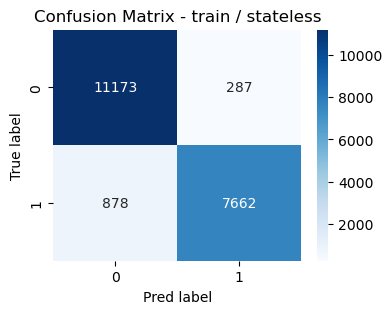


=== Metrics for train / stateful-max ===
Accuracy : 0.9417
Precision: 0.9639
Recall   : 0.8972
F1       : 0.9293

Confusion matrix:
Pred label      0     1
True label             
0           11173   287
1             878  7662


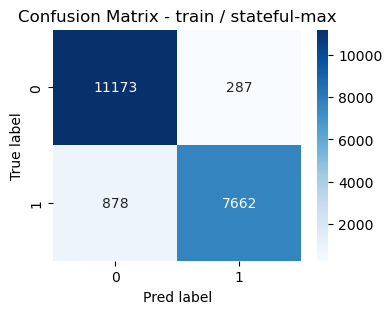


Split: val
[Stateless] Accuracy: 0.9401
[Stateful-max] Accuracy (model preds unchanged): 0.9401

=== Metrics for val / stateless ===
Accuracy : 0.9401
Precision: 0.9616
Recall   : 0.8954
F1       : 0.9273

Confusion matrix:
Pred label      0     1
True label             
0           11156   305
1             893  7646


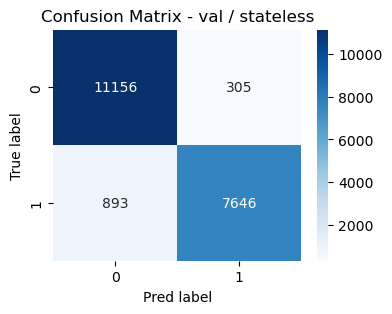


=== Metrics for val / stateful-max ===
Accuracy : 0.9401
Precision: 0.9616
Recall   : 0.8954
F1       : 0.9273

Confusion matrix:
Pred label      0     1
True label             
0           11156   305
1             893  7646


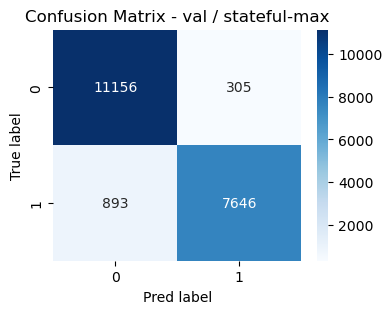


Split: test
[Stateless] Accuracy: 0.9947
[Stateful-max] Accuracy (model preds unchanged): 0.9947

=== Metrics for test / stateless ===
Accuracy : 0.9947
Precision: 0.9977
Recall   : 0.9916
F1       : 0.9946

Confusion matrix:
Pred label      0     1
True label             
0           10123    23
1              83  9771


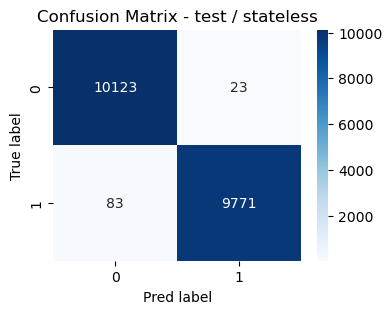


=== Metrics for test / stateful-max ===
Accuracy : 0.9947
Precision: 0.9977
Recall   : 0.9916
F1       : 0.9946

Confusion matrix:
Pred label      0     1
True label             
0           10123    23
1              83  9771


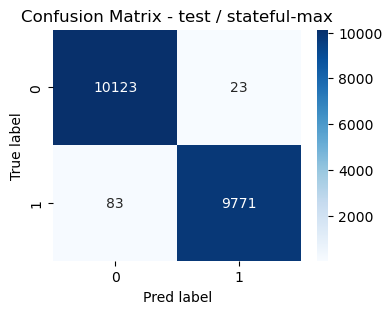

In [14]:
USE_SANITIZATION_FOR_CLASSIFICATION = False  # keep False for clean evaluation
SESSION_LEN = 5
WINDOW_SIZE = 5
AGG_MODE = "max"  # "max" is best to catch any high-risk turn in a window

results = {}  # split -> dict(stateless=..., stateful=...)
metrics = {}  # split -> dict(stateless=..., stateful=...)

for split_name, df in real_datasets.items():
    print(f"\n==============================")
    print(f"Split: {split_name}")
    print(f"==============================")

    # Stateless baseline (United3 behavior)
    df_stateless = run_pipeline_stateless(df, use_sanitization_for_classification=USE_SANITIZATION_FOR_CLASSIFICATION)
    acc_stateless = (df_stateless["pred"] == df_stateless["label"]).mean()
    print(f"[Stateless] Accuracy: {acc_stateless:.4f}")

    # Stateful (synthetic sessions)
    df_sessions = assign_synthetic_sessions(df, session_len=SESSION_LEN, seed=42)
    df_stateful = run_pipeline_stateful(df_sessions, window_size=WINDOW_SIZE, agg_mode=AGG_MODE,
                                        use_sanitization_for_classification=USE_SANITIZATION_FOR_CLASSIFICATION)
    acc_stateful = (df_stateful["pred"] == df_stateful["label"]).mean()
    print(f"[Stateful-{AGG_MODE}] Accuracy (model preds unchanged): {acc_stateful:.4f}")

    results[split_name] = {"stateless": df_stateless, "stateful": df_stateful}

    # Metrics (model classification)
    metrics[split_name] = {
        "stateless": compute_basic_metrics(df_stateless, f"{split_name} / stateless"),
        "stateful": compute_basic_metrics(df_stateful, f"{split_name} / stateful-{AGG_MODE}"),
    }



=== Policy Confusion Matrix: train / stateless ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,11273,25,162
1,1003,7223,314


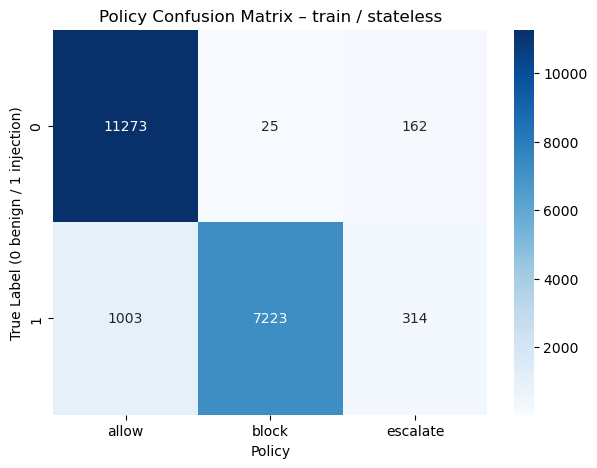


=== Policy Confusion Matrix: train / stateful-max ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,5321,5792,347
1,451,7913,176


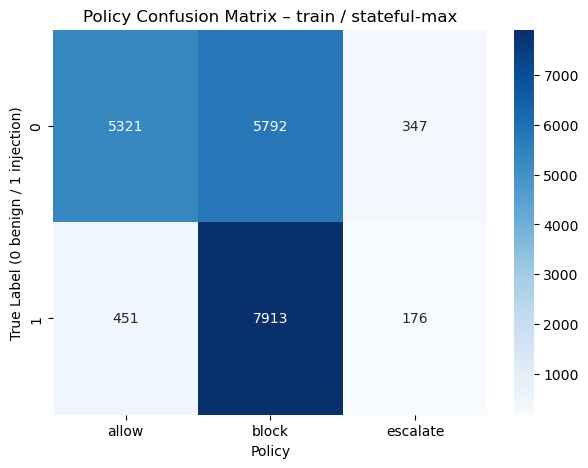


=== Policy Confusion Matrix: val / stateless ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,11247,28,186
1,1012,7158,369


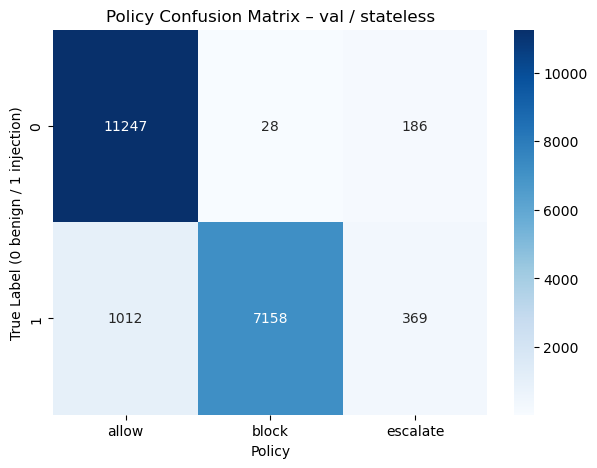


=== Policy Confusion Matrix: val / stateful-max ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,5396,5685,380
1,493,7826,220


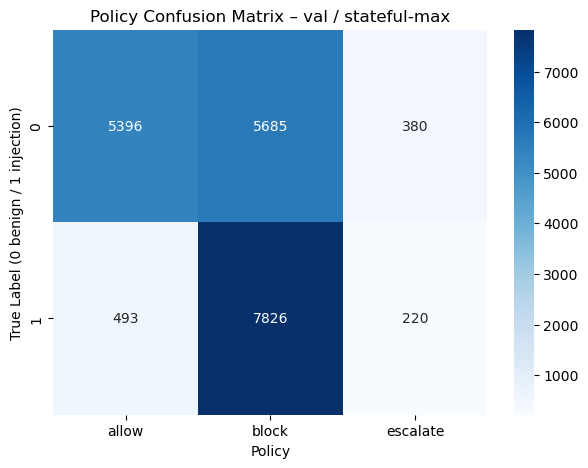


=== Policy Confusion Matrix: test / stateless ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,10126,11,9
1,87,9744,23


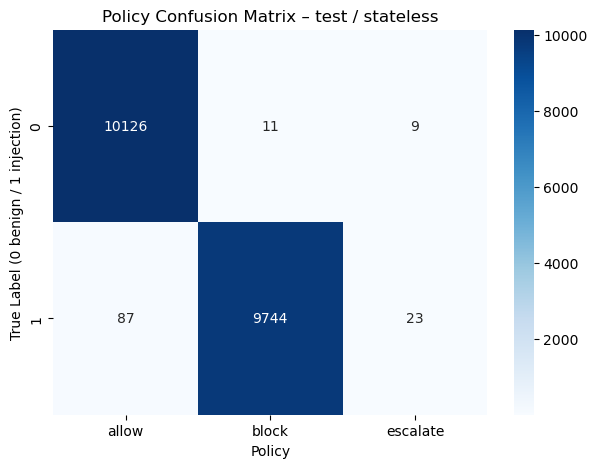


=== Policy Confusion Matrix: test / stateful-max ===


Policy,allow,block,escalate
True Label (0 benign / 1 injection),,,
0,3856,6277,13
1,35,9814,5


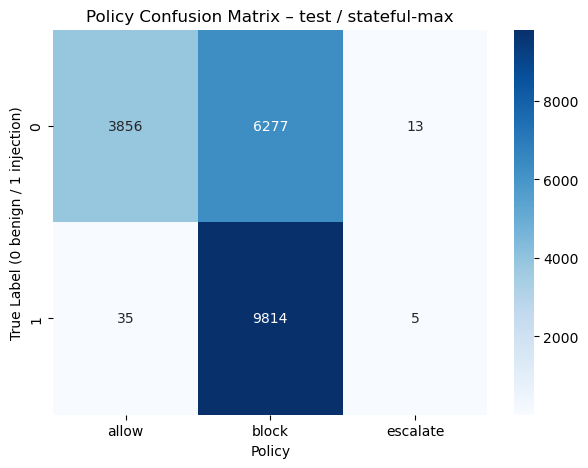

In [15]:
def policy_confusion(df, title):
    policy_order = ["allow", "block", "escalate"]
    cm = pd.crosstab(
        df["label"],
        df["policy"],
        rownames=["True Label (0 benign / 1 injection)"],
        colnames=["Policy"],
        dropna=False
    ).reindex(index=[0,1], columns=policy_order, fill_value=0)

    print(f"\n=== Policy Confusion Matrix: {title} ===")
    display(cm)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Policy Confusion Matrix – {title}")
    plt.show()

for split_name in results:
    policy_confusion(results[split_name]["stateless"], f"{split_name} / stateless")
    policy_confusion(results[split_name]["stateful"], f"{split_name} / stateful-{AGG_MODE}")


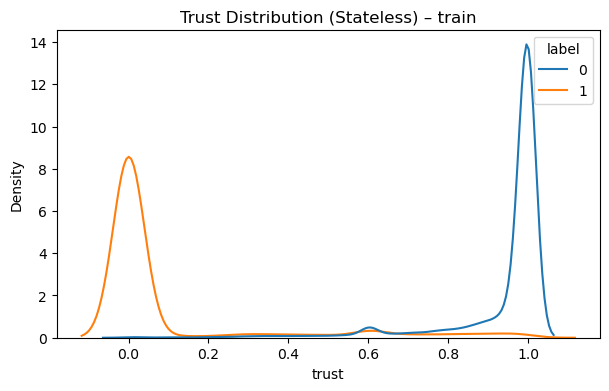

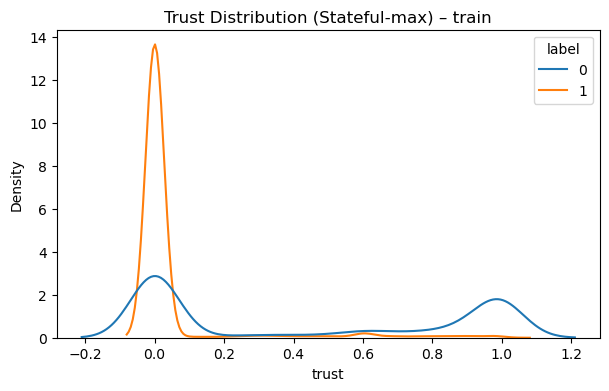

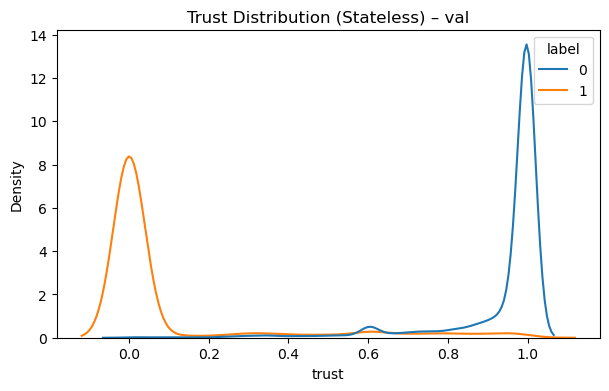

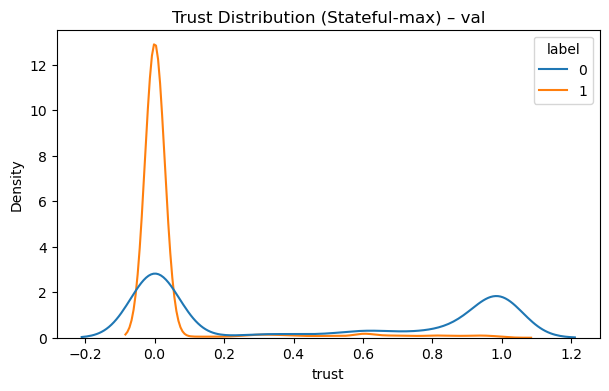

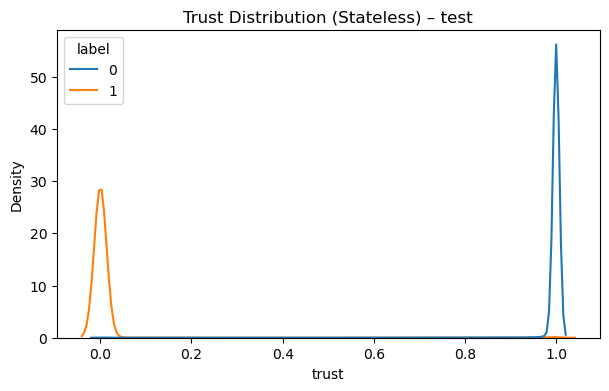

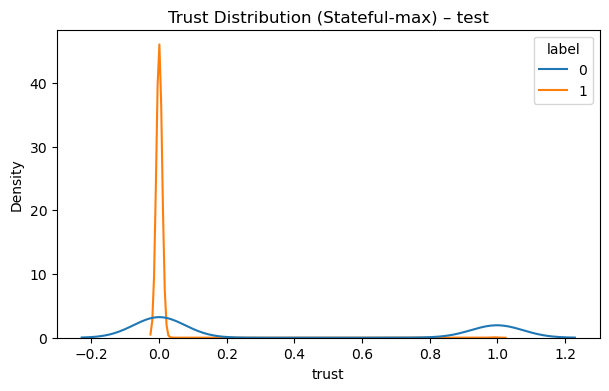

In [16]:
def plot_trust_distributions(df_a, df_b, title_a, title_b, split_name):
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df_a, x="trust", hue="label", common_norm=False)
    plt.title(f"Trust Distribution (Stateless) – {split_name}")
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df_b, x="trust", hue="label", common_norm=False)
    plt.title(f"Trust Distribution (Stateful-{AGG_MODE}) – {split_name}")
    plt.show()

for split_name in results:
    plot_trust_distributions(
        results[split_name]["stateless"],
        results[split_name]["stateful"],
        "stateless",
        f"stateful-{AGG_MODE}",
        split_name
    )


In [17]:
OUTPUT_DIR = "responsible_autonomy_outputs_notebook4"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for split_name, packs in results.items():
    packs["stateless"].to_csv(os.path.join(OUTPUT_DIR, f"{split_name}_stateless.csv"), index=False)
    packs["stateful"].to_csv(os.path.join(OUTPUT_DIR, f"{split_name}_stateful_{AGG_MODE}.csv"), index=False)

# Save summary metrics
rows = []
for split_name, pack in metrics.items():
    for mode, m in pack.items():
        rows.append({"split": split_name, "mode": mode, **m})
metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "summary_metrics.csv"), index=False)

print("Saved results to:", OUTPUT_DIR)
metrics_df


Saved results to: responsible_autonomy_outputs_notebook4


,split,mode,accuracy,precision,recall,f1
0,train,stateless,0.94175,0.963895,0.897190,0.929347
1,train,stateful,0.94175,0.963895,0.897190,0.929347
2,val,stateless,0.94010,0.961640,0.895421,0.927350
3,val,stateful,0.94010,0.961640,0.895421,0.927350
4,test,stateless,0.99470,0.997652,0.991577,0.994605
5,test,stateful,0.99470,0.997652,0.991577,0.994605


In [18]:
def policy_delta(stateless_df, stateful_df, split_name):
    stateless_counts = stateless_df["policy"].value_counts(normalize=True)
    stateful_counts = stateful_df["policy"].value_counts(normalize=True)

    policies = ["allow", "escalate", "block"]
    rows = []
    for p in policies:
        rows.append({
            "split": split_name,
            "policy": p,
            "stateless_%": stateless_counts.get(p, 0.0),
            "stateful_%": stateful_counts.get(p, 0.0),
            "delta_%": stateful_counts.get(p, 0.0) - stateless_counts.get(p, 0.0),
        })
    return pd.DataFrame(rows)

policy_deltas = []
for split in results:
    policy_deltas.append(
        policy_delta(
            results[split]["stateless"],
            results[split]["stateful"],
            split
        )
    )

policy_delta_df = pd.concat(policy_deltas, ignore_index=True)
policy_delta_df


,split,policy,stateless_%,stateful_%,delta_%
0,train,allow,0.61380,0.28860,-0.32520
1,train,escalate,0.02380,0.02615,0.00235
2,train,block,0.36240,0.68525,0.32285
3,val,allow,0.61295,0.29445,-0.31850
4,val,escalate,0.02775,0.03000,0.00225
5,val,block,0.35930,0.67555,0.31625
6,test,allow,0.51065,0.19455,-0.31610
7,test,escalate,0.00160,0.00090,-0.00070
8,test,block,0.48775,0.80455,0.31680
